<a href="https://colab.research.google.com/github/valentine96/Demand-Planning-and-Forecasting/blob/main/notebooks/01_Data_Cleaning_and__EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01 — Data Cleaning and Exploratory Data Analysis (EDA)

This notebook performs initial data loading, data understanding, merging, cleaning, and exploratory analysis for the Demand Planning and Forecasting capstone project.

### Key Tasks:
- Load raw train, test, and store datasets from Google Drive  
- Inspect structure and understand the role of each dataset  
- Merge store metadata with the daily sales datasets  
- Handle missing values and incorrect data types   
- Conduct basic exploratory data analysis  
- Export cleaned dataset for Notebook 02 (Feature Engineering)

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Show all dataframe columns when printing
pd.set_option('display.max_columns', None)

# Apply a clean grid background style to all plots
sns.set(style="whitegrid")

In [ ]:
# mount google drive since the data is in google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to our shared Capstone_Data folder
path = "/content/drive/MyDrive/Capstone_Data/"

# Load the datasets
train_df = pd.read_csv(path + "train.csv")
test_df  = pd.read_csv(path + "test.csv")
store_df = pd.read_csv(path + "store.csv")

In [ ]:
# inspect datasets structure

print("TRAIN SET")
display(train_df.head())
train_df.info()

print("\nTEST SET")
display(test_df.head())
test_df.info()

print("\nSTORE METADATA")
display(store_df.head())
store_df.info()


TRAIN SET


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB

TEST SET


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB

STORE METADATA


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
unique_holidays = train_df["Store"].unique()
print(unique_holidays)

[   1    2    3 ... 1113 1114 1115]


## Data Understanding

After inspecting the raw datasets we summarize their structure as follows:

### **1. train.csv — Historical Daily Sales Data**
This dataset contains transactional, day-by-day sales information for each store.  
It includes the following key attributes:

- **Store** – Unique store identifier.  
- **DayOfWeek** – Encodes the day (1–7), useful for weekly seasonality.  
- **Date** – The date of the transaction.  
- **Sales** – *Target variable* representing the daily revenue of each store.  
- **Customers** – Number of customers visiting that day.  
- **Open** – Indicates whether the store was open (1) or closed (0).  
- **Promo** – Whether the store had a promotion running.  
- **StateHoliday** – Public holidays (a = public holiday, b = Easter, c = Christmas, 0 = none).  
- **SchoolHoliday** – Whether schools were closed.

The training dataset consists of **~1 million records**, reflecting multi-year daily sales patterns across **1,115 stores**.  
It forms the foundation for modeling and learning demand behavior.


### **2. test.csv — Forecasting Input Dataset**
The test dataset has a similar structure to the training data, *except that the Sales and Customers columns are missing*, since those are the values we want to forecast.

It includes:
- Store  
- DayOfWeek  
- Date  
- Open  
- Promo  
- StateHoliday  
- SchoolHoliday  

This dataset contains **41,088 entries**, representing the days for which predictions will be generated.


### **3. store.csv — Store-Level Metadata**
This file provides store-specific characteristics that explain why different stores exhibit different sales profiles.  
These attributes do **not** appear in train/test, making this file essential for enrichment.

Key attributes include:

- **StoreType** – Store category (a, b, c, d)  
- **Assortment** – Level of product variety (a = basic, b = extra, c = extended)  
- **CompetitionDistance** – Distance to nearest competitor  
- **CompetitionOpenSinceMonth/Year** – When competing stores opened  
- **Promo2** – Whether the store participates in a continuous promotion program  
- **Promo2SinceWeek/Year** – When Promo2 started  
- **PromoInterval** – Months when Promo2 is active (e.g., Jan,Apr,Jul,Oct)

This dataset contains **1,115 records**, one for each store, ensuring every store in train/test has corresponding metadata.


### **Why this matters in our project**

- The **train/test** datasets contain operational, day-to-day sales signals.  
- The **store** dataset contains structural, long-term business characteristics.

To build a high-quality forecasting model, we must **combine operational patterns (promotions, holidays, weekly cycles)** with  
**store characteristics (type, assortment, competition).**

This integrated dataset provides a richer understanding of demand and directly improves forecast accuracy.



In [ ]:
# merge the test and train data with store data
train_df = train_df.merge(store_df, on="Store", how="left")
test_df  = test_df.merge(store_df, on="Store", how="left")

train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## The Need for Merging Datasets

The daily sales data (train/test) does not include essential store attributes such as store type, assortment level, or competition proximity. These variables significantly influence sales behavior.

To enrich the dataset and build a more accurate forecasting model, we merge:
- **train.csv + store.csv**
- **test.csv + store.csv**

We join the datasets using the common key:

- **Store** (unique store identifier)

We perform a **left join**, ensuring all records in train/test remain intact, and store metadata is added alongside.

This results in a single, enriched dataset where each daily record now includes both:
- operational daily signals (promo, open, holiday), and  
- structural store attributes (type, assortment, competition).

This merged dataset becomes the foundation for data cleaning, feature engineering, and forecasting.


### **Data Cleaning**

In [ ]:
# continue with inspection after merging
#  Train set structure

print("TRAIN SET SHAPE:", train_df.shape)
train_df.info()
train_df.head()

TRAIN SET SHAPE: (1017209, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-n

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
# Test set structure
print("TEST SET SHAPE:", test_df.shape)
test_df.info()
test_df.head()


TEST SET SHAPE: (41088, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2            

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [ ]:
# Check for missing values
print("MISSING VALUES — MERGED TRAIN")
display(train_df.isna().sum().sort_values(ascending=False))

print("\nMISSING VALUES — MERGED TEST")
display(test_df.isna().sum().sort_values(ascending=False))

# check data types
print(" BEFORE CLEANING — TRAIN DATA TYPES")
display(train_df.dtypes)

print(" BEFORE CLEANING — TEST DATA TYPES")
display(test_df.dtypes)


MISSING VALUES — MERGED TRAIN


,0
Promo2SinceWeek,508031
PromoInterval,508031
Promo2SinceYear,508031
CompetitionOpenSinceYear,323348
CompetitionOpenSinceMonth,323348
CompetitionDistance,2642
DayOfWeek,0
Store,0
Date,0
Sales,0



MISSING VALUES — MERGED TEST


,0
PromoInterval,17232
Promo2SinceYear,17232
Promo2SinceWeek,17232
CompetitionOpenSinceMonth,15216
CompetitionOpenSinceYear,15216
CompetitionDistance,96
Open,11
Id,0
Store,0
StoreType,0


 BEFORE CLEANING — TRAIN DATA TYPES


,0
Store,int64
DayOfWeek,int64
Date,object
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64
StoreType,object


 BEFORE CLEANING — TEST DATA TYPES


,0
Id,int64
Store,int64
DayOfWeek,int64
Date,object
Open,float64
Promo,int64
StateHoliday,object
SchoolHoliday,int64
StoreType,object
Assortment,object


In [ ]:
# Create a data cleaning funtion to be used for both test and train merged sets
def clean_dataset(df, is_train=False):
    """
    Cleans the Rossmann merged dataset (train or test).

    Parameters
    ----------
    df : DataFrame
        Merged dataset containing daily sales + store metadata.

    is_train : bool
        If True, applies additional cleaning steps specific to the training dataset.

    Returns
    -------
    df : DataFrame
        Cleaned dataset ready for feature engineering.
    """


    # Handle missing values

    # CompetitionDistance: missing means unknown → fill with median
    df['CompetitionDistance'] = df['CompetitionDistance'] \
        .fillna(df['CompetitionDistance'].median())

    # Competition opening details:
    # Missing means no competition was recorded → fill with 0
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0)
    df['CompetitionOpenSinceYear']  = df['CompetitionOpenSinceYear'].fillna(0)

    # Promo2-related fields:
    # Missing means store does NOT participate in Promo2 → fill with 0
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0)
    df['PromoInterval']   = df['PromoInterval'].fillna("None")

    # For the test set, missing "Open" values must be filled with 1
    if not is_train:
        df['Open'] = df['Open'].fillna(1)


    # Fix data types

    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Ensure holiday + promo interval columns have consistent string type
    df['StateHoliday'] = df['StateHoliday'].astype(str)
    df['PromoInterval'] = df['PromoInterval'].astype(str)


    # Train-only cleaning

    if is_train:
        # Remove impossible rows: stores closed (Open=0) but with sales > 0
        df = df[(df['Open'] == 1) | (df['Sales'] == 0)]

    return df


In [ ]:
# Apply the cleaning function

train_df = clean_dataset(train_df, is_train=True)
test_df  = clean_dataset(test_df, is_train=False)

In [ ]:
# Check after cleaning
print("CLEANED TRAIN SHAPE:", train_df.shape)
display(train_df.isna().sum())

print("\nCLEANED TEST SHAPE:", test_df.shape)
display(test_df.isna().sum())

print("\nAFTER CLEANING — TRAIN DATA TYPES")
display(train_df.dtypes)

print("\nAFTER CLEANING — TEST DATA TYPES")
display(test_df.dtypes)


CLEANED TRAIN SHAPE: (1017209, 18)


,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0



CLEANED TEST SHAPE: (41088, 17)


,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
StoreType,0
Assortment,0



AFTER CLEANING — TRAIN DATA TYPES


,0
Store,int64
DayOfWeek,int64
Date,datetime64[ns]
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64
StoreType,object



AFTER CLEANING — TEST DATA TYPES


,0
Id,int64
Store,int64
DayOfWeek,int64
Date,datetime64[ns]
Open,float64
Promo,int64
StateHoliday,object
SchoolHoliday,int64
StoreType,object
Assortment,object


## Data Cleaning

The Rossmann dataset contains missing values, mixed data types, and a few logical inconsistencies that must be addressed.

Below, we outline the cleaning steps taken and the reasoning behind each method.

### 1. Handling Missing Values

The merged dataset includes missing values in several store-level metadata fields:

- **CompetitionDistance**
- **CompetitionOpenSinceMonth**, **CompetitionOpenSinceYear**
- **Promo2SinceWeek**, **Promo2SinceYear**, **PromoInterval**
- **Open** (in the test set only)

We addressed these as follows:

#### **• CompetitionDistance — filled with median**
Using the median is appropriate because:
- It is robust to extreme distances (outliers)
- Missing values simply indicate that the distance to a competitor was not recorded

#### **• CompetitionOpenSinceMonth/Year — filled with 0**
A value of **0** is used to represent missing competition data because:
- Many stores do not have competition information
- 0 serves as a neutral placeholder indicating “competition not applicable or unknown”

#### **• Promo2 fields — filled with 0**
For stores that do **not** participate in Promo2, related fields (start week/year/interval) should logically be zero.

This method prevents erroneous model behavior such as interpreting missing values as meaningful signals.

#### **• Open (Test set only) — filled with 1**
A small number of test rows had missing “Open” values.  
These were filled with **1** because:
- Kaggle’s Rossmann guidelines recommend assuming the store was open unless stated otherwise
- Removing rows is not allowed in the test set
- Most missing Open values occur during normal operating periods

### 2. Fixing Incorrect and Mixed Data Types

Certain fields in both datasets contained mixed values (numbers + strings):

- **StateHoliday**
- **PromoInterval**

To ensure consistency and prevent modeling errors:

- **StateHoliday** was converted to string to avoid type conflicts (e.g., 0, '0', 'a')
- **PromoInterval** was converted to string and missing values replaced with `"None"`
- **Date** was converted from object → datetime to allow extraction of year, month, week, and day features

These conversions ensure both training and test data share identical structures.

### 3. Removing Invalid Records (Training set only)

In the training data, some rows indicate the store was **closed** (`Open = 0`) but still have **positive sales**.  
These rows are logically impossible.

We removed such records because:

- A closed store cannot generate sales
- Keeping them would distort demand patterns
- This issue does NOT affect the test set, where row removal is not permitted

### 4. Ensuring Consistency Between Train and Test Sets

A key requirement for machine learning workflows is that **both datasets must contain the same cleaned features and data types**.  
Our pipeline ensures this by:

- Applying shared cleaning steps to both datasets
- Applying train-only logic where appropriate
- Maintaining test set structure for prediction


## Exploratory Data Analysis (EDA)

With the datasets cleaned and merged, the next step is to explore the underlying sales patterns and store characteristics.  
The objective of EDA is to understand:

- How sales behave over time  
- Which store attributes influence sales  
- What patterns or trends exist in the dataset  
- Whether the merged features (competition, promo, assortment, etc.) create meaningful differences in performance  

This step helps us validate our assumptions, identify outliers, detect seasonality, and uncover important relationships that will guide feature engineering and model selection.


###**Sales Distribution**

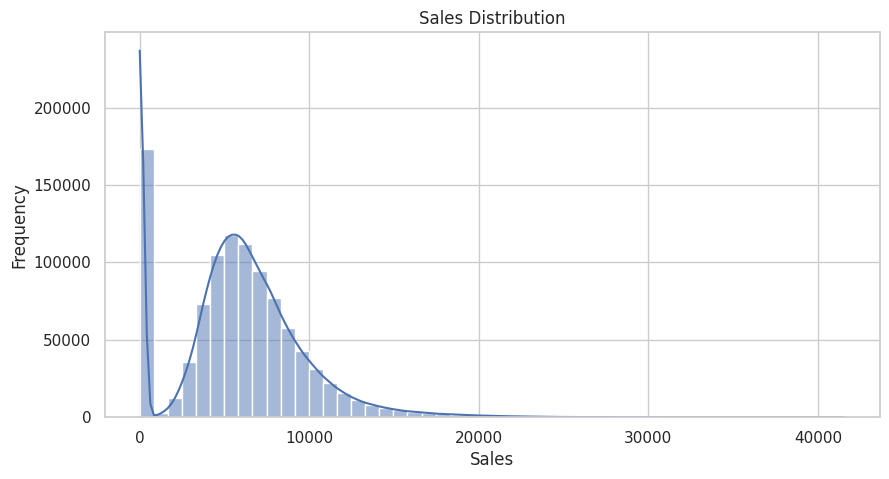

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(train_df['Sales'], bins=50, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

The sales distribution is strongly right-skewed, with most days showing moderate sales and a few days reaching very high volumes. The spike near zero reflects closed or low-activity days. This variation and presence of outliers highlight the need for models that can capture both typical demand and occasional spikes.

###**Sales Over Time**

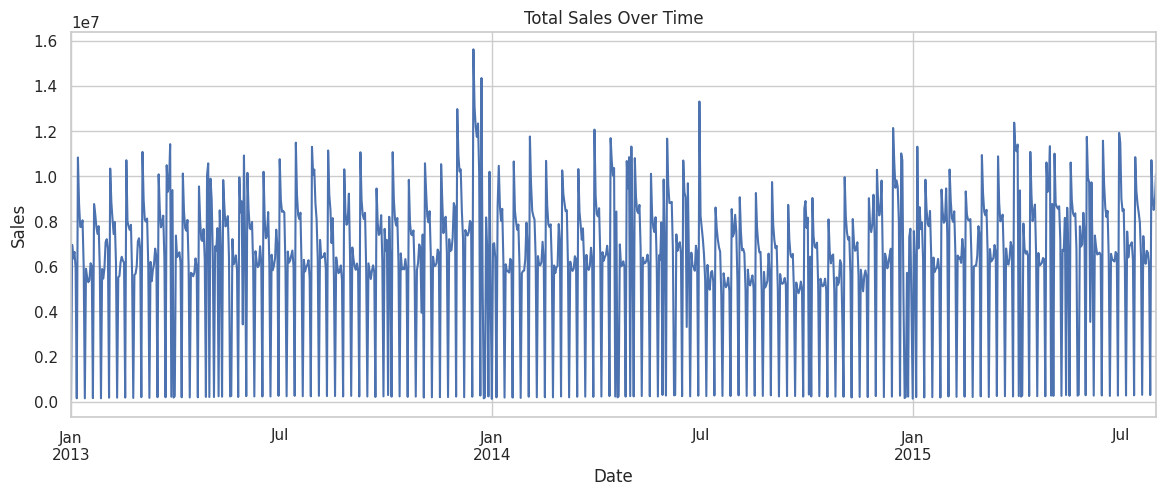

In [ ]:
train_date_sales = train_df.groupby("Date")["Sales"].sum()

plt.figure(figsize=(14,5))
train_date_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

The time series shows strong weekly seasonality with repeating peaks and dips, along with occasional high spikes likely driven by promotions or holidays. Overall sales remain relatively stable across years, but the fluctuations indicate consistent demand cycles.

###**Sales by Day Of Week**

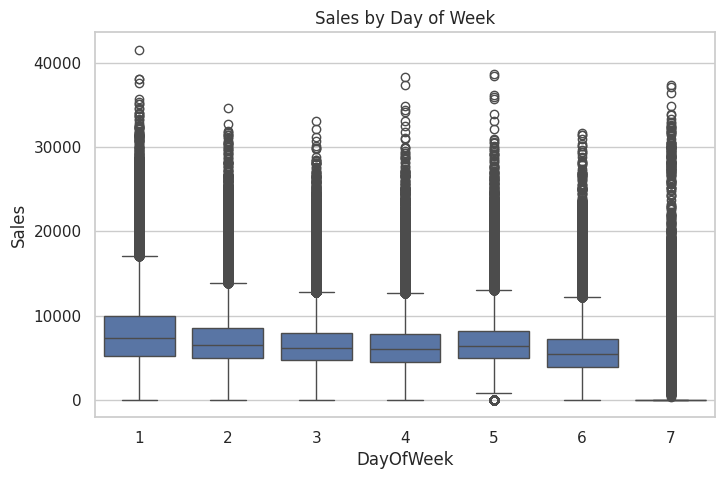

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x="DayOfWeek", y="Sales", data=train_df)
plt.title("Sales by Day of Week")
plt.show()

Sales vary across the week, with Day 1 showing the highest median sales and the most outliers, indicating stronger demand on that day. The remaining days follow a relatively stable pattern with smaller variations. The spread and outliers across all days suggest consistent weekly cycles with occasional high-demand surges.

###**Sales: Promo Vs No Promo**

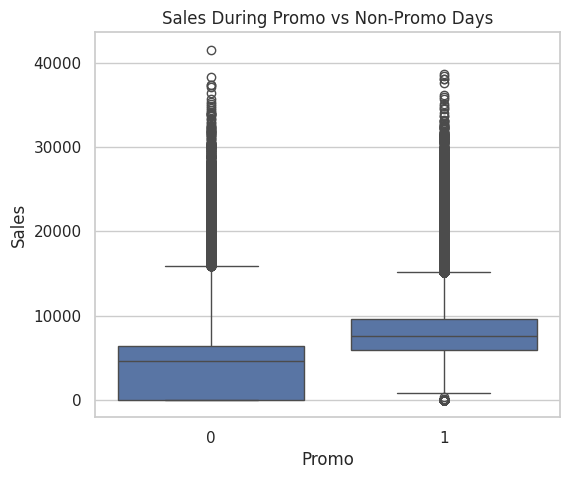

In [ ]:
plt.figure(figsize=(6,5))
sns.boxplot(x="Promo", y="Sales", data=train_df)
plt.title("Sales During Promo vs Non-Promo Days")
plt.show()

Sales are noticeably higher during promotional periods, with promo days showing a higher median and a wider spread of values. This suggests that promotions significantly boost demand, leading to both increased average sales and more frequent high-sales outliers.

###**Sales by Store Assortment**

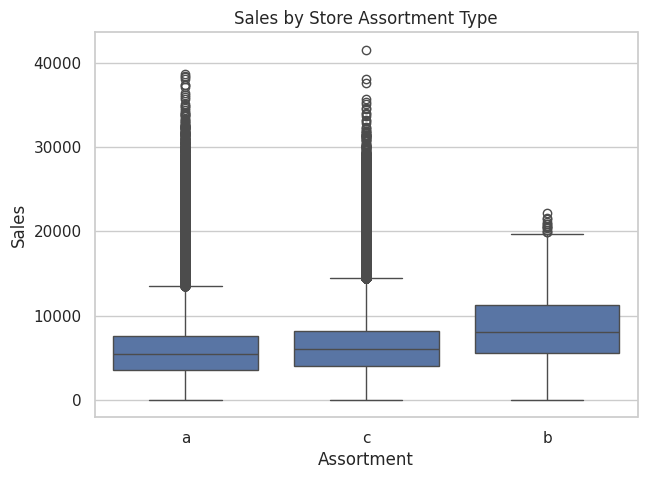

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(x="Assortment", y="Sales", data=train_df)
plt.title("Sales by Store Assortment Type")
plt.show()

Stores with assortment type b show noticeably higher median sales compared to types a and c, suggesting that broader or premium product assortments drive stronger demand. Assortment type c exhibits higher variability, indicating inconsistent performance across stores.

###**Customer Vs Sales(Relationship)**

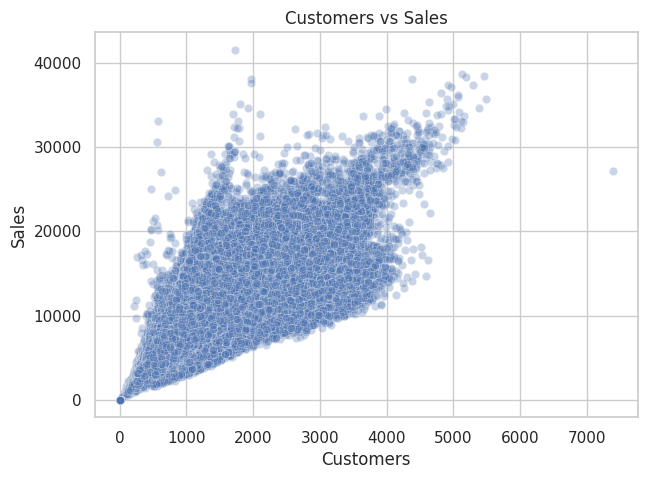

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="Customers", y="Sales", data=train_df, alpha=0.3)
plt.title("Customers vs Sales")
plt.show()

There is a strong positive relationship between customer count and sales, showing that stores with more customers consistently generate higher revenue. The increasing spread at higher customer volumes also indicates greater variability in spending patterns among larger crowds

###**Competition Distance Vs Sales**

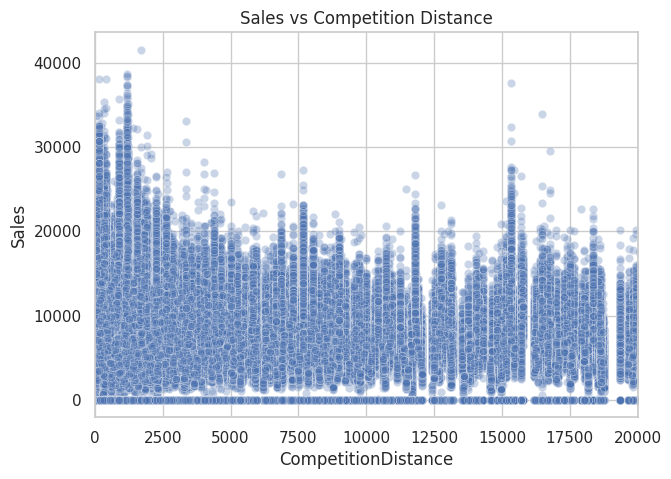

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="CompetitionDistance", y="Sales", data=train_df, alpha=0.3)
plt.xlim(0, 20000)
plt.title("Sales vs Competition Distance")
plt.show()

Sales tend to be higher when competitors are located closer to the store, suggesting that nearby competition may increase overall customer traffic in the area. As competition distance increases, sales gradually decline and become more dispersed, indicating weaker competitive influence at farther distances.

###**Correlation Heatmap for Numeric Columns**

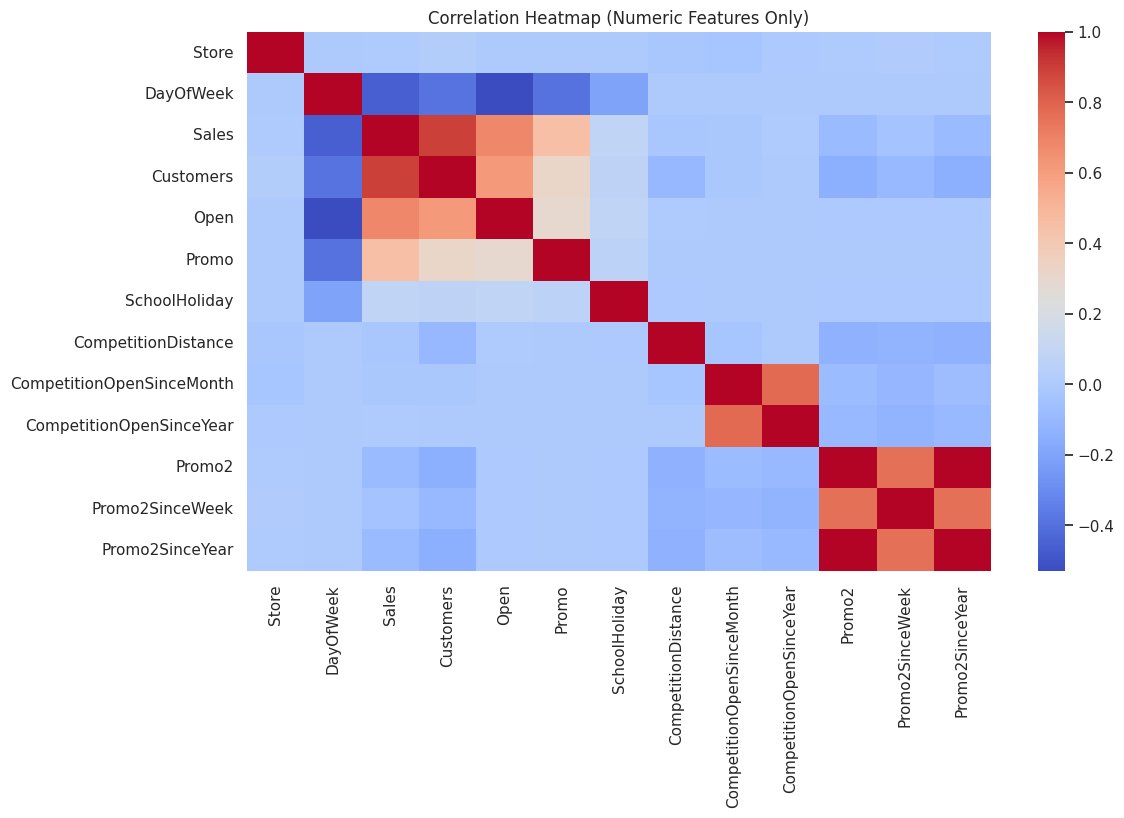

In [ ]:
plt.figure(figsize=(12,7))

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64'])

sns.heatmap(numeric_cols.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

The heatmap shows a strong positive correlation between Sales and Customers, confirming that foot traffic is the main driver of revenue. Promo also shows a moderate positive link with sales, while most other features—including competition and holiday variables—exhibit weak correlations, suggesting their effects are more subtle and non-linear.

In [ ]:
# Save the cleaned datasets
clean_train_path = '/content/drive/MyDrive/Demand_Planning_Project/clean_train.csv'
clean_test_path  = '/content/drive/MyDrive/Demand_Planning_Project/clean_test.csv'

train_df.to_csv(clean_train_path, index=False)
test_df.to_csv(clean_test_path, index=False)